In [1]:
import numpy as np
import pandas as pd

In [71]:
excluding_list = [
    'price', 'id', 'latitude', 
    'longitude', 'host_id', 
    'last_review', 'name',
    'host_name'
    ]

categorical = [
    'neighbourhood_group',
    'neighbourhood',
    'room_type'
    ]

continuous = [
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
    ] 

data = pd.read_csv('./AB_NYC_2019.csv')

In [3]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
data.shape

(48895, 16)

In [65]:
data[categorical].nunique()

neighbourhood_group      5
neighbourhood          221
room_type                3
dtype: int64

In [66]:
low_card_categorical = [
    'neighbourhood_group',
    'room_type'
]

high_card_categorical = [
    'neighbourhood',
]

In [72]:
data[low_card_categorical + continuous].isna().sum()    

neighbourhood_group                   0
room_type                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [15]:
data['reviews_per_month'].min()

np.float64(0.01)

<Axes: >

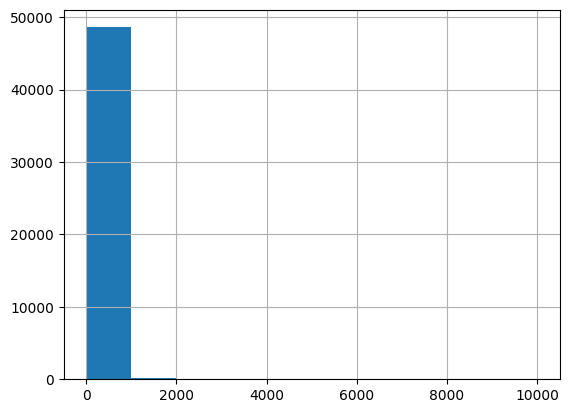

In [21]:
data['price'].hist(bins=10)

<Axes: >

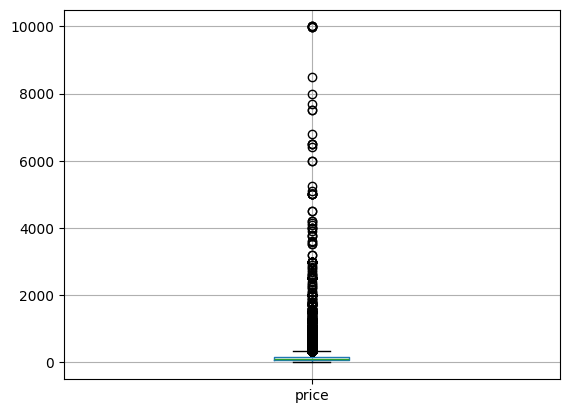

In [23]:
data[['price']].boxplot()

<Axes: >

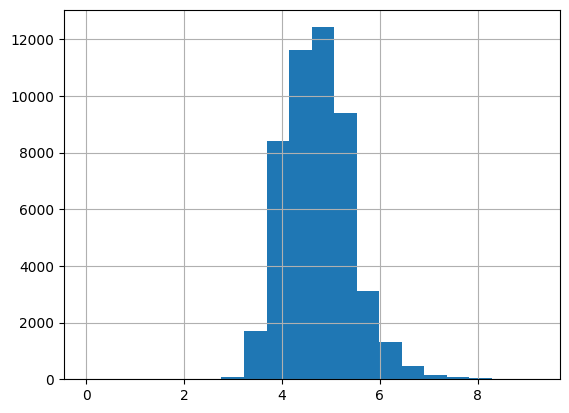

In [27]:
np.log1p(data['price']).hist(bins=20)

<Axes: >

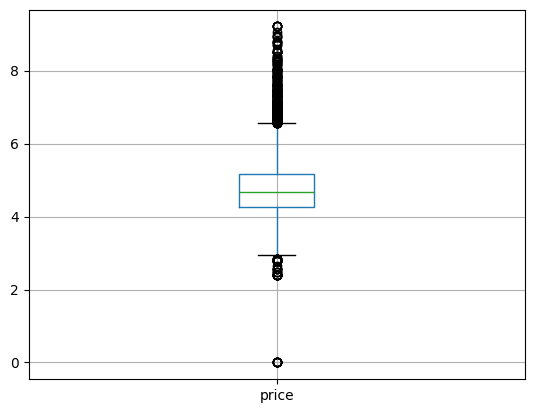

In [28]:
data[['price']].apply(lambda x: np.log1p(x)).boxplot()

array([[<Axes: title={'center': 'price'}>]], dtype=object)

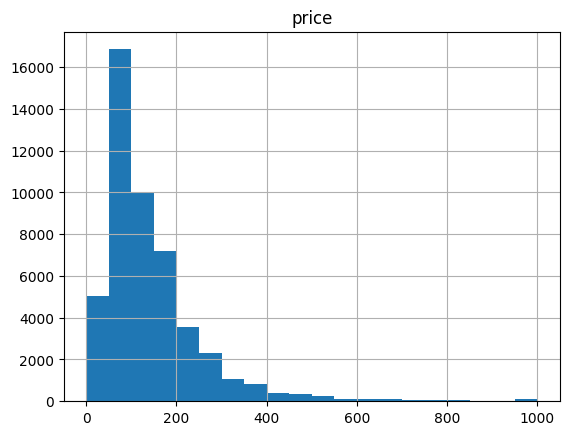

In [ ]:
data[['price']][data['price'] <= 1000].hist(bins=20) # Resembles more common distributions found in e-commerce or other sales with long-tail products.

array([[<Axes: title={'center': 'price'}>]], dtype=object)

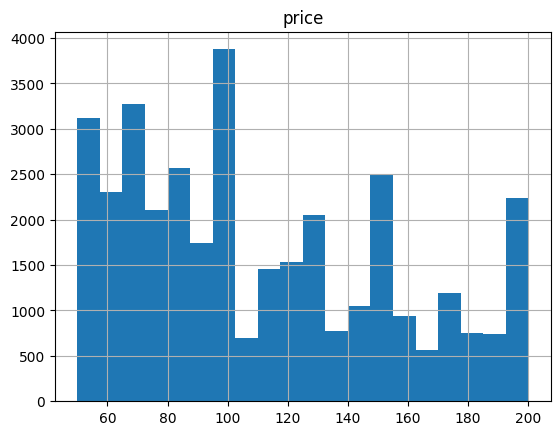

In [ ]:
data[['price']][(data.price >= 50) & (data.price <= 200)].hist(bins=20) # More uniform distribution

In [31]:
price_capped = data.price <= 1000
price_window = (data.price >= 50) & (data.price <= 200)

<Axes: >

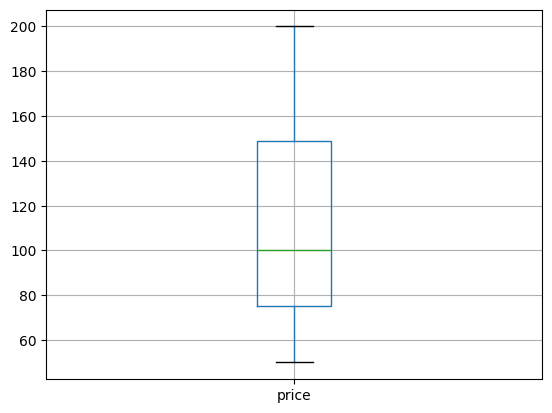

In [33]:
data[['price']][price_window].boxplot()

### Prepare four different targets

In [34]:
target_mean = (data["price"] > data["price"].mean()).astype(int)
target_median = (data["price"] > data["price"].median()).astype(int)
target_multiclass = pd.qcut(data["price"], q=5, labels=False)
target_regression = data["price"]

In [35]:
(target_mean.value_counts(), target_median.value_counts(), target_multiclass.value_counts())

(price
 0    34016
 1    14879
 Name: count, dtype: int64,
 price
 0    24472
 1    24423
 Name: count, dtype: int64,
 price
 3    10809
 0    10063
 1     9835
 2     9804
 4     8384
 Name: count, dtype: int64)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

In [73]:
categorical_onehot = OneHotEncoder(
    handle_unknown='ignore'
)
numeric_passthrough = SimpleImputer(strategy='constant', fill_value=0)
numeric_standardization = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

In [74]:
column_transform = ColumnTransformer(
    [
        ('categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_passthrough, continuous)
        ],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0
)

In [75]:
X = column_transform.fit_transform(data)
print(type(X), X.dtype, X.shape)

<class 'numpy.ndarray'> float64 (48895, 13)


## Linear Regression

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import cross_validate, KFold

In [81]:
column_transform = ColumnTransformer(
    [
        ('categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_passthrough, continuous)
        ],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0
)

model = LinearRegression()

model_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transform),
        #('standardize', numeric_standardization),
        ('model', model)
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse = make_scorer(root_mean_squared_error)
cv_scores = cross_validate(
    estimator=model_pipeline,
    X=data[price_window],
    y=target_regression[price_window],
    scoring=rmse,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
 f"fit: {fit_time:0.2f}", 
 f"secs pred: {score_time:0.2f} secs")

33.949 (0.274) fit: 0.02 secs pred: 0.01 secs


### L2 Regularization (Ridge) Regression

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

In [82]:
column_transform = ColumnTransformer(
    [
        ('categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_passthrough, continuous)
        ],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0
)

polynomial_expansion = PolynomialFeatures(degree=2)
model = Ridge(alpha=2500.0)
model_pipeline = Pipeline(
    steps=[
        ('processing', column_transform),
        ('poly_expansion', polynomial_expansion),
        ('standardize', numeric_standardization),
        ('model', model)
    ]
)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse = make_scorer(root_mean_squared_error)
cv_scores = cross_validate(
    estimator=model_pipeline,
    X=data[price_window],
    y=target_regression[price_window],
    scoring=rmse,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
 f"fit: {fit_time:0.2f}", 
 f"secs pred: {score_time:0.2f} secs")

33.738 (0.275) fit: 0.12 secs pred: 0.02 secs


In [79]:
len(cv_scores['estimator'][0]['model'].coef_)

105

In [80]:
(cv_scores['estimator'][0]['model'].coef_.round(5)!=0).sum()

np.int64(91)

### L1 Regularization (Lasso) Regression

In [ ]:
model = Lasso(alpha=0.1) # The higher the stronger regularization
model_pipeline = Pipeline(
    steps=[
        ('processing', column_transform),
        ('poly_expansion', polynomial_expansion),
        ('standardize', numeric_standardization),
        ('model', model)
    ]
)

cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse = make_scorer(root_mean_squared_error)
cv_scores = cross_validate(
    estimator=model_pipeline,
    X=data[price_window],
    y=target_regression[price_window],
    scoring=rmse,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
 f"fit: {fit_time:0.2f}", 
 f"secs pred: {score_time:0.2f} secs")

33.718 (0.269) fit: 9.05 secs pred: 0.02 secs


In [84]:
(cv_scores['estimator'][0]['model'].coef_.round(5) !=0).sum()

np.int64(53)

### Logistic Regression

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [87]:
accuracy = make_scorer(accuracy_score)
cv = KFold(n_splits=5, shuffle=True, random_state=0)

column_transform = ColumnTransformer(
    [
        ('categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_standardization, continuous)
        ],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0
)
model = LogisticRegression(
    solver='saga',
    penalty=None,
    max_iter=1000
)
model_pipeline = Pipeline(
    steps=[
        ('processing', column_transform),
        ('model', model)
    ]
)
cv_scores = cross_validate(
    estimator=model_pipeline,
    X=data,
    y=target_median,
    scoring=accuracy,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
 f"fit: {fit_time:0.2f}", 
 f"secs pred: {score_time:0.2f} secs")

0.821 (0.004) fit: 1.15 secs pred: 0.01 secs


### Logistic Regression for MultiClass 

In [89]:
from sklearn.multiclass import OneVsRestClassifier

In [94]:
accuracy = make_scorer(accuracy_score)
cv = KFold(n_splits=5, shuffle=True, random_state=0)

column_transform = ColumnTransformer(
    [
        ('categories', categorical_onehot, low_card_categorical),
        ('numeric', numeric_standardization, continuous)
        ],
        remainder='drop',
        verbose_feature_names_out=False,
        sparse_threshold=0.0
)
model = OneVsRestClassifier(
    LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    C=0.1,
    max_iter=1000
))
model_pipeline = Pipeline(
    steps=[
        ('processing', column_transform),
        ('model', model)
    ]
)
cv_scores = cross_validate(
    estimator=model_pipeline,
    X=data,
    y=target_multiclass,
    scoring=accuracy,
    cv=cv,
    return_train_score=True,
    return_estimator=True,
)

mean_cv = np.mean(cv_scores['test_score'])
std_cv = np.std(cv_scores['test_score'])    
fit_time = np.mean(cv_scores['fit_time'])
score_time = np.mean(cv_scores['score_time'])   
print(f"{mean_cv:0.3f} ({std_cv:0.3f})", 
 f"fit: {fit_time:0.2f}", 
 f"secs pred: {score_time:0.2f} secs")

0.435 (0.002) fit: 0.97 secs pred: 0.02 secs


### TweedieRegressor for Poisson, Gamma and Tweedie Distributions

In [95]:
from sklearn.linear_model import TweedieRegressor

In [97]:
experiments = [
    ['normal', 0, float('-inf')],
    ['poisson', 1, 0.0],
    ['tweedie', 1.5, 0.1],
    ['gamma', 2, 0.1],
    ['inverse gaussian', 3, 0.1]
]

for experiment, power, min_val in experiments:
    rmse = make_scorer(root_mean_squared_error)
    cv = KFold(n_splits=5, shuffle=True, random_state=0)

    column_transform = ColumnTransformer(
        [
            ('categories', categorical_onehot, low_card_categorical),
            ('numeric', numeric_standardization, continuous)
            ],
            remainder='drop',
            verbose_feature_names_out=False,
            sparse_threshold=0.0
    )
    model = TweedieRegressor(power=power, max_iter=1_000)
    model_pipeline = Pipeline(
        steps=[
            ('processing', column_transform),
            ('model', model)
        ]
    )
    cv_scores = cross_validate(
        estimator=model_pipeline,
        X=data,
        y=target_regression.clip(lower=min_val),
        scoring=rmse,
        cv=cv,
        return_train_score=True,
        return_estimator=True,
    )

    mean_cv = np.mean(cv_scores['test_score'])
    std_cv = np.std(cv_scores['test_score'])    
    fit_time = np.mean(cv_scores['fit_time'])
    score_time = np.mean(cv_scores['score_time'])   
    print(f"{experiment:18}: {mean_cv:0.3f} ({std_cv:0.3f})", 
    f"fit: {fit_time:0.2f}", 
    f"secs pred: {score_time:0.2f} secs")

normal            : 233.224 (15.849) fit: 0.04 secs pred: 0.01 secs
poisson           : 227.385 (16.212) fit: 0.08 secs pred: 0.01 secs
tweedie           : 228.109 (16.174) fit: 0.05 secs pred: 0.01 secs
gamma             : 233.371 (15.864) fit: 0.04 secs pred: 0.01 secs
inverse gaussian  : 239.567 (15.454) fit: 0.04 secs pred: 0.01 secs
